###  MicroGrad demo

In [25]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [26]:
from littlegrad.engine import Value
from littlegrad.nn import Neuron, Layer, MLP

In [27]:
np.random.seed(1337)
random.seed(1337)

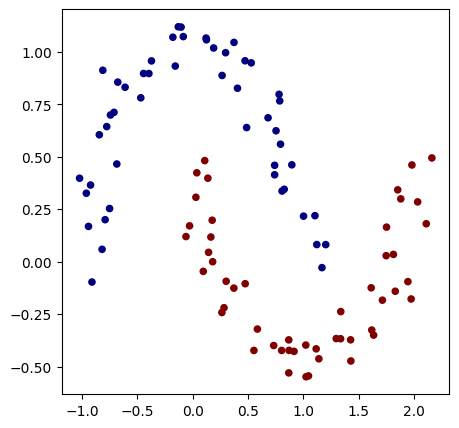

In [28]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [29]:
# initialize a model 
model = MLP(2, [25, 15, 2]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2)], Layer of [ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25)], Layer of [Linear_Neuron(15), Linear_Neuron(15)]]
number of parameters 497


In [30]:
# loss function
def softmax(logits):
  counts = [(logit-np.max(logits)+500).exp() for logit in logits]
  #denominator = sum(counts)
  probs = [count / sum(counts) for count in counts]
  log_softmax = [(logit-np.max(logits)+500) - sum(counts).log() for logit in logits]
  return probs, log_softmax

X = (X-np.average(X)) / np.std(X)  #data normalization
def loss(batch_size=None):

    if batch_size is None:  #dataloader
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] #shuffles the X indexes and returns the first 10
        Xb, yb = X[ri], y[ri]

    losses, accuracy = [], []
    for (xrow, yrow) in zip(Xb, yb):
        inputs = list(map(Value, xrow))  #Value(xrow[i])
        outputs = model(inputs)  #forward pass
        probs, log_softmax = softmax(outputs)
        losses.append(-sum([log_softmax[index] * int(index == yrow) for index in range(len(log_softmax))]))
        accuracy.append(yrow == np.argmax(probs))
    data_loss = sum(losses) / len(losses)
    # Janky L2 regularization 
    # (adding the normal l2 exceeded recursion depth for backward() topo sort, 
    #  so I used p.data instead. this meant that I had to multiply it into total_loss, otherwise p.grad would ignore this new l2
    #alpha = 1e-4
    #reg_loss = alpha * sum((p.data**2 for p in model.parameters())) / data_loss
    total_loss = data_loss #* (1 + reg_loss)

    return total_loss, sum(accuracy) / len(accuracy)


In [31]:
# optimization
epochs = 12
for k in range(epochs):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    #print('total_loss:', total_loss.children)
    #print('parameters:', model.parameters())
    # update (sgd)
    #learning_rate = 1.0 - 0.9*k/epochs
    learning_rate = 0.1
    for p in model.parameters():
        #p.momentum = 0.1*p.grad + 0.9*p.momentum  #testing
        #p.data -= learning_rate * p.momentum  #testing
        p.data -= learning_rate * p.grad

    #print('parameters:', model.parameters())
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 4.534824289632767, accuracy 50.0%
step 1 loss 1.774822094254447, accuracy 50.0%
step 2 loss 0.6908865010869915, accuracy 49.0%
step 3 loss 0.49491445507265835, accuracy 65.0%
step 4 loss 0.43772754171828865, accuracy 72.0%
step 5 loss 0.40401979833138624, accuracy 76.0%
step 6 loss 0.3800880664481076, accuracy 78.0%
step 7 loss 0.36150231237171626, accuracy 82.0%
step 8 loss 0.3467753969270228, accuracy 83.0%
step 9 loss 0.3344132692428798, accuracy 84.0%
step 10 loss 0.32369763774475757, accuracy 85.0%
step 11 loss 0.3143738255184019, accuracy 85.0%


(-2.319448285874285, 1.930551714125715)

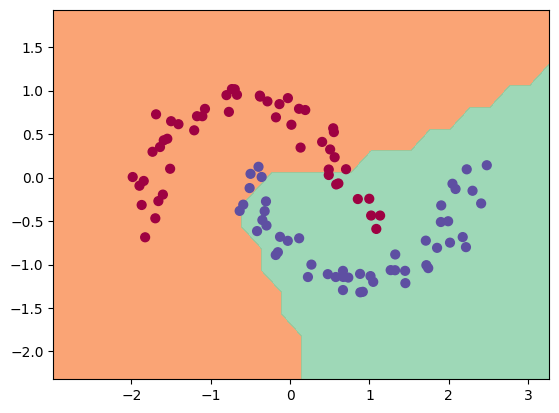

In [32]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#outputs = list(map(model, inputs))
#probs = list(map(softmax, inputs))
#scores = np.array([np.argmax([p.data for p in prob]) for prob in probs])
scores = []
for xrow in Xmesh:
    inputs = list(map(Value, xrow))  #Value(xrow[i])
    outputs = model(inputs)  #forward pass
    probs, _ = softmax(outputs)  #softmax layer
    scores.append(np.argmax([prob.data for prob in probs]))

#Z = np.array([s.data > 0 for s in scores])
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
